In [6]:
from sympy import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy as sp
from scipy import optimize

In [389]:
v = -1
PWS = [np.array([1,1,1]),np.array([1,-1,v]),np.array([-1,+1,v]),np.array([-1,-1,1])]

def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[0]
def h2(x):
    return x[1]
def H1(x): 
    return H(h1(x))
def H2(x):
    return H(h2(x))

def f1(x):
    return PWS[0]
def f2(x):
    return PWS[1]
def f3(x):
    return PWS[2]
def f4(x):
    return PWS[3]
rd = 5 #decimal places to which a & b are rounded before duplicates are removed from newton raphson method 
#rd needs to be quite small, otherwise it counts 0.999999 as being a legal a or b
nr_num = 10 #number of starting points of newton raphson
nr_maxiter = 100 #num of iterations of newton raphson
error = 0.1
tan_tol = 0.1

def f_i(x,v):
    return H1(x)*H2(x)*(f4(x,v)-f3(x,v)-f2(x,v) + f1(x,v)) + H1(x)*(f3(x,v) - f1(x,v)) + H2(x)*(f2(x,v) - f1(x,v)) + f1(x,v)

def norm_components(x,v):
    w = np.zeros((5,3),dtype = np.float64) # In (4,2) works, but this keeps it consistent with Dieci notation
    
    w[1,1:3] = f1(x,v)[0:2]
    w[2,1:3] = f2(x,v)[0:2]
    w[3,1:3] = f3(x,v)[0:2]
    w[4,1:3] = f4(x,v)[0:2]

    return w

def assumptions(x):
    w = norm_components(x,v)
    #print(w)
    # Assumption (a)
    #for i in range(1,5):
     #   print('i=',i)
      #  print(H(w[i][1]),H1(x))
       # print(H(w[i][2]),H2(x))
        #print(x)
        #print('w',w[i,:])
        #if H(w[i][1]) == H1(x) and H(w[i][2]) == H2(x):
         #   print('fails')
          #  return False
    # Assumption (b,c)
    bc = 0
    combos_i = [(2,4),(1,3),(3,4),(1,2)]
    ks = [1,1,2,2]
    
    def tan(k,i,j,n):
        if n in [1,3]:
            i,j = j,i #spaghetti code to make it work
        def otherk(k):
            if k == 1:
                return 2
            elif k ==2:
                return 1
        return w[i][otherk(k)]/w[i][k] - w[j][otherk(k)]/w[j][k]
    
    for (n,(k,(i,j))) in enumerate(zip(ks,combos_i)):
        print(tan(k,i,j,n))
        if w[i][k] > 0 and w[j][k] < 0 and tan(k,i,j,n) < 0:
            print('ijk',i,j,k)
            #print(tan(k,i,j,n))
            #print('w',w)
            if -tan_tol <= tan(k,i,j,n) < tan_tol: #first order exit condition
                return False
            bc += 1
    return (bc > 0)

def solver(x,v,debug = 0,solve_method = 'nr'):
    w = norm_components(x,v)
    
    def poly_solver(x,v,debug=0):
        # in this case of h1 and h2, w_i^k will be the first and second components of f_i
        a,b = symbols("a b")
        
        P = ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
        Q = ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
      
        asolns = simplify(solve(Q,a,simplify = False,rational = False,quick=True))
        bsolns = simplify(solve(P,b,simplify = False,rational = False,quick=True))
    
        return asolns,bsolns
    
    def newton_raphson_solver(x,v,debug = 0):
    
        def P(b):
            return ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
    
        def Q(a):
            return ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
        def nr(poly,start):
            return optimize.newton(poly,start,maxiter = nr_maxiter)
    
        #round all the found asolns of Q to the nearest rd decimal place, and remove duplicates (should give list of size 2)
        asolns = list(set([round(nr(Q,a0),rd) for a0 in np.linspace(-1,2,nr_num)]))
        bsolns = list(set([round(nr(P,b0),rd) for b0 in np.linspace(-1,2,nr_num)]))
        return asolns,bsolns
    
    
    if solve_method == 'nr':
        solns = newton_raphson_solver
    if solve_method == 'poly':
        solns = poly_solver
        
    asolns,bsolns = solns(x,v)
    
    all_asolns,all_bsolns = asolns,bsolns #for debug

        
    def h(a):
        return ((1-a)*w[1][1] + a* w[3][1])/ ( (1-a) *w[1][1]+ a* w[3][1]  - ((1-a)*w[2][1] + a * w[4][1] ))
    def g(b):
        return ((1-b)*w[1][2] + b* w[2][2])/ ( (1-b) *w[1][2]+ b* w[2][2]  - ((1-b)*w[3][2] + b * w[4][2] ))
    
    #remove all solutions not in (0,1)
    asolns = [a for a in asolns if 0<a<1]
    bsolns = [b for b in bsolns if 0<b<1]

    hasolns = [h(asoln) for asoln in asolns]
    gbsolns = [g(bsoln) for bsoln in bsolns]
    
    def rel_intersect(list1,list2,inter_error =1e-1):
    #returns the intersection of two sets, with elements equal within some error
    #(only works properly for sets of size 2)
        intersection = []
        for a in list1:
            for b in list2:
                if abs(a-b)<inter_error:
                    intersection += [a]
        return intersection
    #these should both be lists of size one
    legal_asolns = rel_intersect(asolns,gbsolns,error)
    legal_bsolns = rel_intersect(bsolns,hasolns,error)
    
    if debug:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,hasolns)
        print('x =',x)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
    if len(legal_asolns) != 1 or len(legal_bsolns) != 1:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,all_gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,all_hasolns)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
        return 'More than one or no valid (a,b)'
    else:
        return legal_asolns[0],legal_bsolns[0]

def bilinear(x,r,v,solve_method='nr',debug = 0):
    #fuzzify vector field around a r-neighbourhood of \Sigma according to bilinear model
    if abs(h1(x)) < r and abs(h2(x)) < r and assumptions(x):
        solns = solver(x,v,solve_method=solve_method,debug=debug)
        if solns == 'More than one or no valid (a,b)':
            velocity = f_i(x,v)
        else:
            a,b = solns[0],solns[1]
            F_B = (1-a)*(1-b)*f1(x,v) + (1-a)*b*f2(x,v) + a*(1-b)*f3(x,v) + a*b*f4(x,v)
            velocity = F_B
    else:
        velocity = f_i(x,v) #gives the vector field of R_i if outside the fuzzy nbd of \Sigma
    return velocity

def bi_model(tstep,r,v,x0 = (1,2,1),solve_method ='nr',debug = 0):
    yy = np.zeros((n,len(x0)))+x0
    
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'bilinear model')):
        velocity = bilinear(yy[i-1,:],r,v,solve_method=solve_method,debug=debug)
        yy[i,:] = yy[i-1,:] + tstep*velocity
    return yy

n = 300


bilinear model:   0%|                                                                          | 0/300 [00:00<?, ?it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:   6%|████                                                            | 19/300 [00:00<00:01, 188.63it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  12%|███████▉                                                        | 37/300 [00:00<00:01, 179.44it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  18%|███████████▎                                                    | 53/300 [00:00<00:01, 169.97it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  23%|██████████████▋                                                 | 69/300 [00:00<00:01, 164.43it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  29%|██████████████████▊                                             | 88/300 [00:00<00:01, 170.55it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  34%|█████████████████████▋                                         | 103/300 [00:00<00:01, 158.27it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  41%|█████████████████████████▊                                     | 123/300 [00:00<00:01, 166.84it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  46%|█████████████████████████████▏                                 | 139/300 [00:00<00:00, 163.85it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  53%|█████████████████████████████████▍                             | 159/300 [00:00<00:00, 172.92it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  59%|████████████████████████████████████▉                          | 176/300 [00:01<00:00, 163.27it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)


bilinear model:  65%|████████████████████████████████████████▋                      | 194/300 [00:01<00:00, 166.68it/s]

(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  70%|████████████████████████████████████████████▎                  | 211/300 [00:01<00:00, 132.87it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  75%|███████████████████████████████████████████████▍               | 226/300 [00:01<00:00, 120.77it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  80%|██████████████████████████████████████████████████▏            | 239/300 [00:01<00:00, 112.90it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  84%|████████████████████████████████████████████████████▉          | 252/300 [00:01<00:00, 100.72it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  88%|████████████████████████████████████████████████████████        | 263/300 [00:01<00:00, 98.43it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  91%|█████████████████████████████████████████████████████████▌     | 274/300 [00:02<00:00, 100.05it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  95%|████████████████████████████████████████████████████████████▊   | 285/300 [00:02<00:00, 99.57it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


bilinear model:  99%|██████████████████████████████████████████████████████████████▏| 296/300 [00:02<00:00, 100.03it/s]

(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)
(300, 3) (3,) (3,)


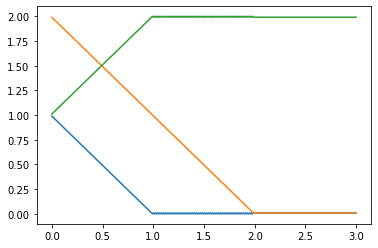

In [390]:
debug = 0

T = 3

tstep = 10**-2#10**-5 +10**-4*2.5 #(10**-5 +10**-4*2.5)*50
r = .01

n = int(T/tstep)
print('n =',n)

tt = np.linspace(0, T, n)

yy = model(tt,r)
plt.plot(tt,yy)

In [168]:
f1 = Array([(e1*(e1+4*e0 - qa1), e0*(3*e0-qa2), e1*(e1+4*e0-qb1), e0*(3*e0-qb2))])
f2 = Array([(e1*(e0+4*e1 - qa1), e0*(3*e1-qa2), e0*(e1+4*e0-qb1), e1*(3*e0-qb2))])
f3 = Array([(e0*(e1+4*e0 - qa1), e1*(3*e0-qa2), e1*(e0+4*e1-qb1), e0*(3*e1-qb2))])
f4 = Array([(e0*(e0+4*e1 - qa1), e1*(3*e1-qa2), e0*(e0+4*e1-qb1), e1*(3*e1-qb2))])

NameError: name 'e1' is not defined

In [857]:
f1 = Array([(p,-1,2)])

p = 4
q = 4


f2 = Array([(p,1,0)])
f3 = Array([(1,p,-1)])
f4 = Array([(-q,-q,1)])

w11 = f1[0]
w12 = f1[1]

w21 = f2[0]
w22 = f2[1]

w31 = f3[0]
w32 = f3[1]

w41 = f4[0]
w42 = f4[1]

g = ((1-b)*w12 + b* w22)/ ( (1-b) *w12+ b* w22  - ((1-b)*w32 + b * w42 ))
P = ((1-b)*w12 + b *w22)*((1-b)*w31 + b *w41) - ((1-b)*w32 + b *w42)*((1-b)*w11 + b *w21)

h = ((1-a)*w11 + a* w31)/ ( (1-a) *w11+ a* w31  - ((1-a)*w21 + a * w41 ))
Q = ((1-a)*w11 + a *w31)*((1-a)*w22 + a *w42) - ((1-a)*w21 + a *w41)*((1-a)*w12 + a *w32)

asolns = simplify(solve(Q,a))
print('asolns = ',asolns)
hasolns = [h.subs(a,asoln) for asoln in asolns]
print('h(asolns) = ',hasolns)

bsolns = simplify(solve(P,b))
print('bsolns = ',bsolns)
gbsolns = [g.subs(b,bsoln) for bsoln in bsolns]
print('g(bsolns) = ',gbsolns)
print(h.subs(a,1/5))

print([(0<=bsoln<=1) for bsoln in bsolns])
#len(asolns)
#asolnslim = [simplify(asoln.subs([(e0,0),(e1,1)])) for asoln in asolns]
#print(asolnslim)
#print(asolnslim[1].subs([(qa1,1.5),(qa2,1.5),(qb1,1),(qb2,1)]))
print([(0<=asoln<=1) for asoln in asolns])

asolns =  [1/5, 8/11]
h(asolns) =  [17/5, 1/2]
bsolns =  [1/2, 17/5]
g(bsolns) =  [nan, 1/5]
3.40000000000000
[True, False]
[True, True]


In [3]:
opportunistic_defection_start = (2.83,2.85,2.73,2.85)
opportunistic_defection_later = (2.85,2.85,2.68,2.68)#(2.8285,2.8270,2.635,2.636)
bjorns_start = (2.8,2.801,2.845,2.99)
debug_bi_start = (2.7937573,  2.79373824, 2.21117745, 2.21118088)

In [400]:
rd = 5 #decimal places to which a & b are rounded before duplicates are removed from newton raphson method 
#rd needs to be quite small, otherwise it counts 0.999999 as being a legal a or b
nr_num = 10 #number of starting points of newton raphson
nr_maxiter = 100 #num of iterations of newton raphson
eps = 0.1 #epsilon value in the eps-greedy algorithm
error = 0.1
tan_tol = 0.1

def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[1] - x[0]
def h2(x):
    return x[3] - x[2]
def H1(x):
    return H(h1(x))
def H2(x):
    return H(h2(x))

def f1(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e1*(e1+4*e0 - x[0]), e0*(3*e0-x[1]), e1*(e1+4*e0-x[2]), e0*(3*e0-x[3]))])
def f2(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e1*(e0+4*e1 - x[0]), e0*(3*e1-x[1]), e0*(e1+4*e0-x[2]), e1*(3*e0-x[3]))])
def f3(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e0*(e1+4*e0 - x[0]), e1*(3*e0-x[1]), e1*(e0+4*e1-x[2]), e0*(3*e1-x[3]))])
def f4(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([e0*(e0+4*e1 - x[0]), e1*(3*e1-x[1]), e0*(e0+4*e1-x[2]), e1*(3*e1-x[3])])

def f_i(x,eps):
    return H1(x)*H2(x)*(f4(x,eps)-f3(x,eps)-f2(x,eps) + f1(x,eps)) + H1(x)*(f3(x,eps) - f1(x,eps)) + H2(x)*(f2(x,eps) - f1(x,eps)) + f1(x,eps)

def values_before_zero(t,start = bjorns_start):
    x = np.array(start)#np.array([a-t,b-t,c+t])
    return x

def norm_components(x,eps):
    w = np.zeros((5,3),dtype = np.float64) # In (4,2) works, but this keeps it consistent with Dieci notation
    e0 = eps / 2
    e1 = 1 - eps / 2
    qa1,qa2,qb1,qb2 = x[0],x[1],x[2],x[3]
    
    w[1][1] = e0 * (3*e0 - qa2) - e1 * ( e1 + 4*e0 - qa1) #f1(x)[1] - f1(x)[0] 
    w[1][2] = e0 * (3*e0 - qb2) - e1 * ( e1 + 4*e0 - qb1) #f1(x)[3] - f1(x)[2]
    w[2][1] = e0 * (3*e1 - qa2) - e1 * ( e0 + 4*e1 - qa1) #etc
    w[2][2] = e1 * (3*e0 - qb2) - e0 * ( e1 + 4*e0 - qb1)
    w[3][1] = e1 * (3*e0 - qa2) - e0 * ( e1 + 4*e0 - qa1)
    w[3][2] = e0 * (3*e1 - qb2) - e1 * ( e0 + 4*e1 - qb1)
    w[4][1] = e1 * (3*e1 - qa2) - e0 * ( e0 + 4*e1 - qa1)
    w[4][2] = e1 * (3*e1 - qb2) - e0 * ( e0 + 4*e1 - qb1)
    
    return w

def assumptions(x):
    w = norm_components(x,eps)
    
    # Assumption (a)
    
    #for i in range(1,5):
     #   if H(w[i][1]) == H1(x) and H(w[i][2]) == H2(x):
      #      return False
    # Assumption (b,c)
    bc = 0
    combos_i = [(2,4),(1,3),(3,4),(1,2)]
    ks = [1,1,2,2]
    
    def tan(k,i,j,n):
        if n in [1,3]:
            i,j = j,i #spaghetti code to make it work
        def otherk(k):
            if k == 1:
                return 2
            elif k ==2:
                return 1
        return w[i][otherk(k)]/w[i][k] - w[j][otherk(k)]/w[j][k]
    
    for (n,(k,(i,j))) in enumerate(zip(ks,combos_i)):
        if w[i][k] > 0 and w[j][k] < 0 and tan(k,i,j,n) < 0:
            #print('ijk',i,j,k)
            #print(tan(k,i,j,n))
            #print('w',w)
            if -tan_tol <= tan(k,i,j,n) < tan_tol: #first order exit condition
                return False
            bc += 1
    return (bc > 0)

def solver(x,eps,debug = 0,solve_method = 'nr'):
    w = norm_components(x,eps)
    
    def poly_solver(x,eps,debug=0):
        # in this case of h1 and h2, w_i^k will be the first and second components of f_i
        a,b = symbols("a b")
        
        P = ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
        Q = ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
      
        asolns = simplify(solve(Q,a,simplify = False,rational = False,quick=True))
        bsolns = simplify(solve(P,b,simplify = False,rational = False,quick=True))
    
        return asolns,bsolns
    
    def newton_raphson_solver(x,eps,debug = 0):
    
        def P(b):
            return ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
    
        def Q(a):
            return ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
        def nr(poly,start):
            return sp.optimize.newton(poly,start,maxiter = nr_maxiter)
    
        #round all the found asolns of Q to the nearest rd decimal place, and remove duplicates (should give list of size 2)
        asolns = list(set([round(nr(Q,a0),rd) for a0 in np.linspace(-1,2,nr_num)]))
        bsolns = list(set([round(nr(P,b0),rd) for b0 in np.linspace(-1,2,nr_num)]))
        return asolns,bsolns
    
    
    if solve_method == 'nr':
        solns = newton_raphson_solver
    if solve_method == 'poly':
        solns = poly_solver
        
    asolns,bsolns = solns(x,eps)
    
    all_asolns,all_bsolns = asolns,bsolns #for debug

        
    def h(a):
        return ((1-a)*w[1][1] + a* w[3][1])/ ( (1-a) *w[1][1]+ a* w[3][1]  - ((1-a)*w[2][1] + a * w[4][1] ))
    def g(b):
        return ((1-b)*w[1][2] + b* w[2][2])/ ( (1-b) *w[1][2]+ b* w[2][2]  - ((1-b)*w[3][2] + b * w[4][2] ))
    
    #remove all solutions not in (0,1)
    asolns = [a for a in asolns if 0.01<a<0.99]
    bsolns = [b for b in bsolns if 0.01<b<0.99]

    hasolns = [h(asoln) for asoln in asolns]
    gbsolns = [g(bsoln) for bsoln in bsolns]
    
    def rel_intersect(list1,list2,inter_error =1e-1):
    #returns the intersection of two sets, with elements equal within some error
    #(only works properly for sets of size 2)
        intersection = []
        for a in list1:
            for b in list2:
                if abs(a-b)<inter_error:
                    intersection += [a]
        return intersection
    #these should both be lists of size one
    legal_asolns = rel_intersect(asolns,gbsolns,error)
    legal_bsolns = rel_intersect(bsolns,hasolns,error)
    
    if debug:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,hasolns)
        print('x =',x)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
    if len(legal_asolns) != 1 or len(legal_bsolns) != 1:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,all_gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,all_hasolns)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
        return 'More than one or no valid (a,b)'

        
        #raise Exception('More than one or no valid (a,b)')
        
    return legal_asolns[0],legal_bsolns[0]

def sigma_attractive(x):
    # very blunt tool that disables the bilinear method outside of the attractive range of sigma
    # (informed from looking at a graph of the euler method and tests of this bilinear method)
    # lower sliding region                          #upper sliding region
    #print('pizza time')
    a = 0
    for i in range(np.shape(x)[0]):
        if 2.20117745<x[i]<2.75 or 2.79<x[i]<2.84:
            a += 1
    if a == 4:
        return True
    else:
        return False


def bilinear(x,r,eps,solve_method='nr',debug = 0):
    #fuzzify vector field around a r-neighbourhood of \Sigma according to bilinear model
    if (abs(h1(x)) < r and abs(h2(x)) < r) and assumptions(x):
        #print('pizza time')
        solns = solver(x,eps,solve_method=solve_method,debug=debug)
        if solns == 'More than one or no valid (a,b)':
            #This is an inevitable work around: If 
            velocity = f_i(x,eps)
        else:
            a,b = solns[0],solns[1]
            F_B = (1-a)*(1-b)*f1(x,eps) + (1-a)*b*f2(x,eps) + a*(1-b)*f3(x,eps) + a*b*f4(x,eps)
            velocity = F_B
    else:
        velocity = f_i(x,eps) #gives the vector field of R_i if outside the fuzzy nbd of \Sigma
    return velocity

def bi_model(tstep,r,eps,start = (1,2,1,2),solve_method ='nr',debug = 0):
    yy = np.zeros((n,4))+values_before_zero(0,start)
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'bilinear model')):
        velocity = bilinear(yy[i-1,:],r,eps,solve_method=solve_method,debug=debug)
        #if debug:
         #   print('velocity =',velocity)
        yy[i,:] = yy[i-1,:] + tstep*velocity
    return yy

n = 20000


bilinear model:   2%|█▏                                                            | 377/20000 [00:03<05:53, 55.55it/s]

x = [2.72803652 2.72798111 2.69404873 2.69404924]
all_asolns, all_gbsolns : [0.290014735497285, 0.967061782779861] [0.290014735497285, 0.967061782779861]
all_bsolns, all_hasolns : [0.279717770182403, 0.989892742336258] [0.279717770182403, 0.989892742336257]
asolns = [0.290014735497285, 0.967061782779861]
hasolns = [0.279717770182403, 0.989892742336257]
bsolsn= [0.279717770182403, 0.989892742336258]
gbsolns = [0.290014735497285, 0.967061782779861]
legal a [0.290014735497285, 0.967061782779861]
legal b [0.279717770182403, 0.989892742336258]
x = [2.72590239 2.72615846 2.6909139  2.68991446]
all_asolns, all_gbsolns : [0.289761975501961, 0.965466623959614] [0.289761975501961, 0.965466623959614]
all_bsolns, all_hasolns : [0.279421610177919, 0.989983683233710] [0.279421610177919, 0.989983683233710]
asolns = [0.289761975501961, 0.965466623959614]
hasolns = [0.279421610177919, 0.989983683233710]
bsolsn= [0.279421610177919, 0.989983683233710]
gbsolns = [0.289761975501961, 0.965466623959614]
lega

bilinear model:  12%|███████▍                                                     | 2442/20000 [00:04<04:05, 71.58it/s]

x = [2.72557929 2.72487358 2.68653123 2.68731811]
all_asolns, all_gbsolns : [0.290398958135238, 0.964589281521209] [0.290398958135238, 0.964589281521210]
all_bsolns, all_hasolns : [0.278108381214326, 0.989890429307549] [0.278108381214326, 0.989890429307549]
asolns = [0.290398958135238, 0.964589281521209]
hasolns = [0.278108381214326, 0.989890429307549]
bsolsn= [0.278108381214326, 0.989890429307549]
gbsolns = [0.290398958135238, 0.964589281521210]
legal a [0.290398958135238, 0.964589281521209]
legal b [0.278108381214326, 0.989890429307549]
x = [2.72344676 2.72304817 2.68341856 2.6832047 ]
all_asolns, all_gbsolns : [0.290148951778895, 0.963000378178161] [0.290148951778895, 0.963000378178161]
all_bsolns, all_hasolns : [0.277809208774281, 0.989985128445446] [0.277809208774281, 0.989985128445447]
asolns = [0.290148951778895, 0.963000378178161]
hasolns = [0.277809208774281, 0.989985128445447]
bsolsn= [0.277809208774281, 0.989985128445446]
gbsolns = [0.290148951778895, 0.963000378178161]
lega

bilinear model:  24%|██████████████▎                                              | 4712/20000 [00:12<02:38, 96.41it/s]

x = [2.71711862 2.71697616 2.67074164 2.67087525]
all_asolns, all_gbsolns : [0.290095415634724, 0.958459103283229] [0.290095415634723, 0.958459103283229]
all_bsolns, all_hasolns : [0.275512336602206, 0.989946452992392] [0.275512336602206, 0.989946452992393]
asolns = [0.290095415634724, 0.958459103283229]
hasolns = [0.275512336602206, 0.989946452992393]
bsolsn= [0.275512336602206, 0.989946452992392]
gbsolns = [0.290095415634723, 0.958459103283229]
legal a [0.290095415634724, 0.958459103283229]
legal b [0.275512336602206, 0.989946452992392]
x = [2.714438   2.71458739 2.66715476 2.66628829]
all_asolns, all_gbsolns : [0.289789271959558, 0.956749692581666] [0.289789271959558, 0.956749692581666]
all_bsolns, all_hasolns : [0.275144430920949, 0.989913143154052] [0.275144430920949, 0.989913143154052]
asolns = [0.289789271959558, 0.956749692581666]
hasolns = [0.275144430920949, 0.989913143154052]
bsolsn= [0.275144430920949, 0.989913143154052]
gbsolns = [0.289789271959558, 0.956749692581666]
lega

bilinear model:  36%|█████████████████████▍                                      | 7126/20000 [00:23<01:46, 120.71it/s]

x = [2.709323   2.70981954 2.65657439 2.65659805]
all_asolns, all_gbsolns : [0.289824043406783, 0.953170918039378] [0.289824043406784, 0.953170918039378]
all_bsolns, all_hasolns : [0.273063367512197, 0.989940866190622] [0.273063367512197, 0.989940866190621]
asolns = [0.289824043406783, 0.953170918039378]
hasolns = [0.273063367512197, 0.989940866190621]
bsolsn= [0.273063367512197, 0.989940866190622]
gbsolns = [0.289824043406784, 0.953170918039378]
legal a [0.289824043406783, 0.953170918039378]
legal b [0.273063367512197, 0.989940866190622]
x = [2.70938004 2.70995271 2.65663406 2.65678178]
all_asolns, all_gbsolns : [0.289825980029043, 0.953232838906981] [0.289825980029043, 0.953232838906981]
all_bsolns, all_hasolns : [0.273056808537574, 0.989962340572608] [0.273056808537574, 0.989962340572608]
asolns = [0.289825980029043, 0.953232838906981]
hasolns = [0.273056808537574, 0.989962340572608]
bsolsn= [0.273056808537574, 0.989962340572608]
gbsolns = [0.289825980029043, 0.953232838906981]
lega

bilinear model:  49%|█████████████████████████████▋                              | 9897/20000 [00:39<01:26, 116.13it/s]

x = [2.70527945 2.70448048 2.64611089 2.64553968]
all_asolns, all_gbsolns : [0.290248357204209, 0.949035950937022] [0.290248357204209, 0.949035950937021]
all_bsolns, all_hasolns : [0.270970566594408, 0.989998121185612] [0.270970566594409, 0.989998121185612]
asolns = [0.290248357204209, 0.949035950937022]
hasolns = [0.270970566594409, 0.989998121185612]
bsolsn= [0.270970566594408, 0.989998121185612]
gbsolns = [0.290248357204209, 0.949035950937021]
legal a [0.290248357204209, 0.949035950937022]
legal b [0.270970566594408, 0.989998121185612]
x = [2.70323487 2.70378569 2.64418678 2.6449121 ]
all_asolns, all_gbsolns : [0.289902700736138, 0.948888217817484] [0.289902700736138, 0.948888217817484]
all_bsolns, all_hasolns : [0.270608625172311, 0.989875532682156] [0.270608625172311, 0.989875532682155]
asolns = [0.289902700736138, 0.948888217817484]
hasolns = [0.270608625172311, 0.989875532682155]
bsolsn= [0.270608625172311, 0.989875532682156]
gbsolns = [0.289902700736138, 0.948888217817484]
lega

bilinear model:  63%|█████████████████████████████████████▎                     | 12629/20000 [00:52<01:00, 121.44it/s]

x = [2.69962792 2.69900245 2.63475473 2.63507618]
all_asolns, all_gbsolns : [0.290325571008015, 0.945204435047250] [0.290325571008015, 0.945204435047250]
all_bsolns, all_hasolns : [0.268643926703513, 0.989947413670358] [0.268643926703513, 0.989947413670358]
asolns = [0.290325571008015, 0.945204435047250]
hasolns = [0.268643926703513, 0.989947413670358]
bsolsn= [0.268643926703513, 0.989947413670358]
gbsolns = [0.290325571008015, 0.945204435047250]
legal a [0.290325571008015, 0.945204435047250]
legal b [0.268643926703513, 0.989947413670358]
x = [2.69697814 2.69661309 2.63128928 2.63061046]
all_asolns, all_gbsolns : [0.290035146320880, 0.943524902202355] [0.290035146320880, 0.943524902202354]
all_bsolns, all_hasolns : [0.268261415818474, 0.989949176280392] [0.268261415818474, 0.989949176280392]
asolns = [0.290035146320880, 0.943524902202355]
hasolns = [0.268261415818474, 0.989949176280392]
bsolsn= [0.268261415818474, 0.989949176280392]
gbsolns = [0.290035146320880, 0.943524902202354]
lega

bilinear model:  79%|███████████████████████████████████████████████             | 15704/20000 [01:13<02:54, 24.65it/s]

x = [2.69131837 2.69142028 2.62043799 2.62081263]
all_asolns, all_gbsolns : [0.290047713725485, 0.939923088900079] [0.290047713725485, 0.939923088900080]
all_bsolns, all_hasolns : [0.265993543173829, 0.989947102328794] [0.265993543173829, 0.989947102328794]
asolns = [0.290047713725485, 0.939923088900079]
hasolns = [0.265993543173829, 0.989947102328794]
bsolsn= [0.265993543173829, 0.989947102328794]
gbsolns = [0.290047713725485, 0.939923088900080]
legal a [0.290047713725485, 0.939923088900079]
legal b [0.265993543173829, 0.989947102328794]
x = [2.69137631 2.69157093 2.62049947 2.62103035]
all_asolns, all_gbsolns : [0.290048952412461, 0.939999061005707] [0.290048952412460, 0.939999061005707]
all_bsolns, all_hasolns : [0.265983845428867, 0.989967024699071] [0.265983845428867, 0.989967024699071]
asolns = [0.290048952412461, 0.939999061005707]
hasolns = [0.265983845428867, 0.989967024699071]
bsolsn= [0.265983845428867, 0.989967024699071]
gbsolns = [0.290048952412460, 0.939999061005707]
lega

bilinear model:  79%|███████████████████████████████████████████████             | 15708/20000 [01:14<03:34, 20.05it/s]

x = [2.69143424 2.69172144 2.62056094 2.62124788]
all_asolns, all_gbsolns : [0.290050197702110, 0.940074954435748] [0.290050197702111, 0.940074954435748]
all_bsolns, all_hasolns : [0.265974173370790, 0.989986935513281] [0.265974173370789, 0.989986935513281]
asolns = [0.290050197702110, 0.940074954435748]
hasolns = [0.265974173370789, 0.989986935513281]
bsolsn= [0.265974173370790, 0.989986935513281]
gbsolns = [0.290050197702111, 0.940074954435748]
legal a [0.290050197702110, 0.940074954435748]
legal b [0.265974173370790, 0.989986935513281]
x = [2.69092489 2.69130453 2.62013387 2.62097664]
all_asolns, all_gbsolns : [0.289988288445645, 0.940033139489352] [0.289988288445645, 0.940033139489352]
all_bsolns, all_hasolns : [0.265901856822412, 0.989859239535803] [0.265901856822412, 0.989859239535803]
asolns = [0.289988288445645, 0.940033139489352]
hasolns = [0.265901856822412, 0.989859239535803]
bsolsn= [0.265901856822412, 0.989859239535803]
gbsolns = [0.289988288445645, 0.940033139489352]
lega

bilinear model:  79%|███████████████████████████████████████████████▏            | 15711/20000 [01:14<04:16, 16.73it/s]

x = [2.69098284 2.69145529 2.62019536 2.62119422]
all_asolns, all_gbsolns : [0.289989502747334, 0.940109002751114] [0.289989502747334, 0.940109002751114]
all_bsolns, all_hasolns : [0.265892209451548, 0.989879268424686] [0.265892209451548, 0.989879268424686]
asolns = [0.289989502747334, 0.940109002751114]
hasolns = [0.265892209451548, 0.989879268424686]
bsolsn= [0.265892209451548, 0.989879268424686]
gbsolns = [0.289989502747334, 0.940109002751114]
legal a [0.289989502747334, 0.940109002751114]
legal b [0.265892209451548, 0.989879268424686]


bilinear model:  92%|███████████████████████████████████████████████████████▍    | 18485/20000 [01:14<00:31, 48.41it/s]

x = [2.68532938 2.68563009 2.60990028 2.61017951]
all_asolns, all_gbsolns : [0.289938023443810, 0.935993975053725] [0.289938023443810, 0.935993975053725]
all_bsolns, all_hasolns : [0.263970748966027, 0.989920414414877] [0.263970748966027, 0.989920414414877]
asolns = [0.289938023443810, 0.935993975053725]
hasolns = [0.263970748966027, 0.989920414414877]
bsolsn= [0.263970748966027, 0.989920414414877]
gbsolns = [0.289938023443810, 0.935993975053725]
legal a [0.289938023443810, 0.935993975053725]
legal b [0.263970748966027, 0.989920414414877]
x = [2.68538761 2.68578624 2.60996229 2.61040734]
all_asolns, all_gbsolns : [0.289939037193185, 0.936074149278011] [0.289939037193185, 0.936074149278011]
all_bsolns, all_hasolns : [0.263960128761420, 0.989939819723475] [0.263960128761420, 0.989939819723475]
asolns = [0.289939037193185, 0.936074149278011]
hasolns = [0.263960128761420, 0.989939819723475]
bsolsn= [0.263960128761420, 0.989939819723475]
gbsolns = [0.289939037193185, 0.936074149278011]
lega

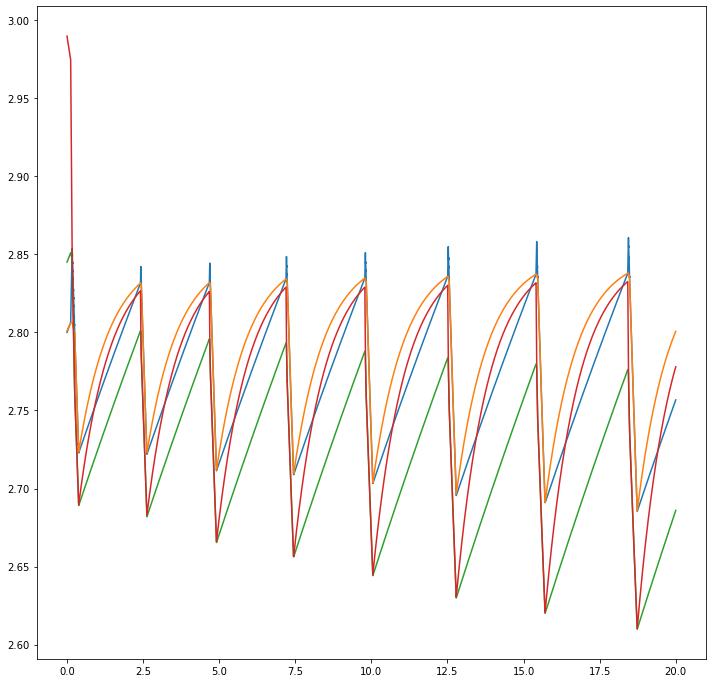

In [401]:
debug = 0
T = 20
start = bjorns_start#[1.65753905, 1.6578653,  1.93788264, 1.93770685]

tstep = 10**-3
r = tstep*1
n = int(T/tstep)
print('n =',n)

tt = np.linspace(0, T, n)

yyy = bi_model(tstep,r,eps,start = start,debug=debug,solve_method ='poly')

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.plot(tt,yyy)

#[2.80669922 2.80671872 2.19416195 2.19408323]

n = 20000


euler_model:  97%|█████████████████████████████████████████████████████████▉  | 19307/20000 [00:01<00:00, 18678.97it/s]

1 1


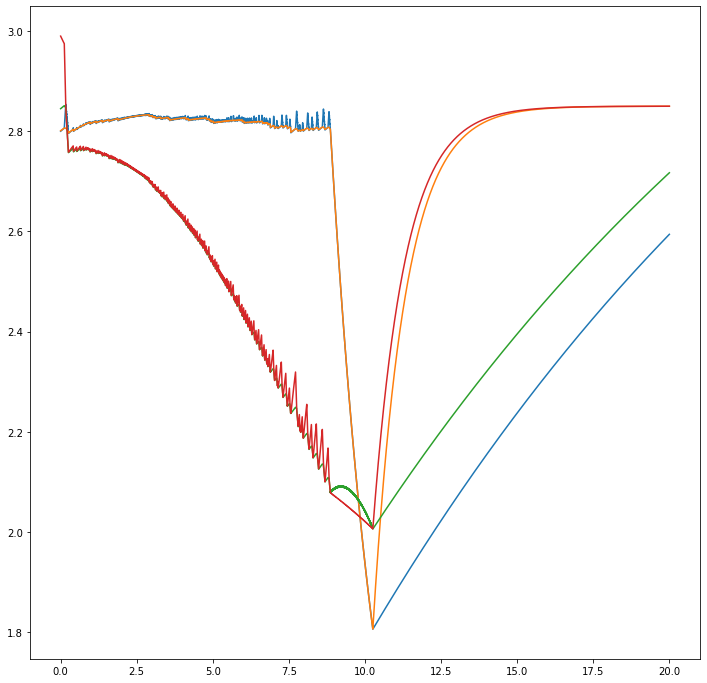

In [347]:
T = 20

tstep = 10**-3
n = int(T/tstep)
print('n =',n)
tt = np.linspace(0, T, n)

def vector(x,i):
        t = tt[i]
        
        #field = which_quadrant(yy[i,:])
        d1 = int(x[1] - x[0] > 0)
        d2 = int(x[3] - x[2] > 0)
        #print(d1,d2)
        #print(yy[i])
        vect = f_i(x)
        #vect = qdot((x[0:2],x[2:4]), (d1,d2))
        #print(qdot((yy[i,0:2],yy[i,2:4]), (1,1)))
        #print(vect)
        if i == n - 2: 
            print(d1,d2)
        return vect
def euler_model(tt,tstep):
    yy = np.zeros((n,4)) + bjorns_start
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'euler_model')):
        yy[i,:] = yy[i-1,:] + tstep*vector(yy[i-1],i-1)
    return yy


fig, ax = plt.subplots(1, figsize=(12, 12))
ax.plot(tt,euler_model(tt,tstep))

In [89]:
F_Bsolns = []
for abar in asolns:
    for bbar in bsolns:
        F_Bsolns += [simplify(F_B.subs([(a,abar),(b,bbar),(e0,0),(e1,1)]))]
print(F_Bsolns)
#F_Bsolns = [F_B.subs(a,bbar) for bbar in bsolns]

[[[(-(qa1 - 4)*(qa1*qb1 + qa1*qb2 - 7*qa1 + qa2*qb1 + qa2*qb2 - qa2 + 5*qb1 - qb2 - sqrt(qa1**2*qb1**2 + 2*qa1**2*qb1*qb2 - 14*qa1**2*qb1 + qa1**2*qb2**2 - 14*qa1**2*qb2 + 49*qa1**2 + 2*qa1*qa2*qb1**2 + 4*qa1*qa2*qb1*qb2 - 16*qa1*qa2*qb1 + 2*qa1*qa2*qb2**2 - 16*qa1*qa2*qb2 + 14*qa1*qa2 - 14*qa1*qb1**2 - 16*qa1*qb1*qb2 + 106*qa1*qb1 - 2*qa1*qb2**2 + 94*qa1*qb2 - 272*qa1 + qa2**2*qb1**2 + 2*qa2**2*qb1*qb2 - 2*qa2**2*qb1 + qa2**2*qb2**2 - 2*qa2**2*qb2 + qa2**2 - 14*qa2*qb1**2 - 16*qa2*qb1*qb2 + 94*qa2*qb1 - 2*qa2*qb2**2 + 10*qa2*qb2 - 80*qa2 + 49*qb1**2 + 14*qb1*qb2 - 272*qb1 + qb2**2 - 80*qb2 + 448) - 8) - (qa1 - 1)*(-qa1*qb1 - qa1*qb2 + 7*qa1 - qa2*qb1 - qa2*qb2 + qa2 + 7*qb1 + 13*qb2 + sqrt(qa1**2*qb1**2 + 2*qa1**2*qb1*qb2 - 14*qa1**2*qb1 + qa1**2*qb2**2 - 14*qa1**2*qb2 + 49*qa1**2 + 2*qa1*qa2*qb1**2 + 4*qa1*qa2*qb1*qb2 - 16*qa1*qa2*qb1 + 2*qa1*qa2*qb2**2 - 16*qa1*qa2*qb2 + 14*qa1*qa2 - 14*qa1*qb1**2 - 16*qa1*qb1*qb2 + 106*qa1*qb1 - 2*qa1*qb2**2 + 94*qa1*qb2 - 272*qa1 + qa2**2*qb1**2 +

In [54]:
blim = [simplify(bbar.subs([(e0,0),(e1,1),(qa1,0),(qa2,0),(qb1,0),(qb2,0)])) for bbar in bsolns]
bproplim = [simplify(bbar.subs([(e0,0),(e1,1),(qa1,0),(qa2,0),(qb1,0),(qb2,0)])) for bbar in bpropsolns]

print(blim)
print(bproplim)
blim == bproplim

[1/6 + sqrt(7)/6, 1/6 - sqrt(7)/6]
[1/6 + sqrt(7)/6, 1/6 - sqrt(7)/6]


True

In [58]:
a = [2.01,3.01]
b = [2,3]
d = rel_intersect(a,a)
print(d)
c = rel_intersect(a,b)
rel_intersect(c,a)

[2.01, 3.01]


[2.01, 3.01]

In [18]:
a = 1
b = a
b +=1
print(a,b)

1 2


In [ ]:
    a = 0
    for i in range(np.shape(x)[0]):
        if 2.20117745<x[i]<2.75 or 2.79<x[i]<2.84:
            a += 1
    if a == 4:
        return True
    else:
        return False


In [ ]:
    if (np.all(2.20117745<x) and np.all(x<2.75)) or (np.all(2.79<x) and np.all(x<2.84)):
        print('pizza time')
        return True
    else:
        return False

In [30]:
a =[[],[]]
print(a)

[[], []]


In [97]:
rd = 5 #decimal places to which a & b are rounded before duplicates are removed from newton raphson method
nr_num = 5 #number of starting points of newton raphson
nr_maxiter = 50 #num of iterations of newton raphson
eps = 0.1 #epsilon value in the eps-greedy algorithm


def H(x):
    if x >= 0:
        return 1
    else:
        return 0
def h1(x):
    return x[1] - x[0]
def h2(x):
    return x[3] - x[2]
def H1(x):
    return H(h1(x))
def H2(x):
    return H(h2(x))

def f1(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e1*(e1+4*e0 - x[0]), e0*(3*e0-x[1]), e1*(e1+4*e0-x[2]), e0*(3*e0-x[3]))])
def f2(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e1*(e0+4*e1 - x[0]), e0*(3*e1-x[1]), e0*(e1+4*e0-x[2]), e1*(3*e0-x[3]))])
def f3(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e0*(e1+4*e0 - x[0]), e1*(3*e0-x[1]), e1*(e0+4*e1-x[2]), e0*(3*e1-x[3]))])
def f4(x,eps=eps):
    e0 = eps / 2
    e1 = 1 - eps / 2
    return np.array([(e0*(e0+4*e1 - x[0]), e1*(3*e1-x[1]), e0*(e0+4*e1-x[2]), e1*(3*e1-x[3]))])

def f_i(x,eps):
    return H1(x)*H2(x)*(f4(x,eps)-f3(x,eps)-f2(x,eps) + f1(x,eps)) + H1(x)*(f3(x,eps) - f1(x,eps)) + H2(x)*(f2(x,eps) - f1(x,eps)) + f1(x,eps)

def values_before_zero(t,start = bjorns_start):
    x = np.array(start)#np.array([a-t,b-t,c+t])
    return x

def solver(x,eps,debug = 0,solve_method = 'nr'):
    e0 = eps / 2
    e1 = 1 - eps / 2
    qa1,qa2,qb1,qb2 = x[0],x[1],x[2],x[3]
    w11 = e0 * (3*e0 - qa2) - e1 * ( e1 + 4*e0 - qa1)
    w12 = e0 * (3*e0 - qb2) - e1 * ( e1 + 4*e0 - qb1)
    w21 = e0 * (3*e1 - qa2) - e1 * ( e0 + 4*e1 - qa1)
    w22 = e1 * (3*e0 - qb2) - e0 * ( e1 + 4*e0 - qb1)
    w31 = e1 * (3*e0 - qa2) - e0 * ( e1 + 4*e0 - qa1)
    w32 = e0 * (3*e1 - qb2) - e1 * ( e0 + 4*e1 - qb1)
    w41 = e1 * (3*e1 - qa2) - e0 * ( e0 + 4*e1 - qa1)
    w42 = e1 * (3*e1 - qb2) - e0 * ( e0 + 4*e1 - qb1)
    
    def poly_solver(x,eps,debug=0):
        # in this case of h1 and h2, w_i^k will be the first and second components of f_i
        a,b = symbols("a b")
        
        P = ((1-b)*w12 + b *w22)*((1-b)*w31 + b *w41) - ((1-b)*w32 + b *w42)*((1-b)*w11 + b *w21)
        Q = ((1-a)*w11 + a *w31)*((1-a)*w22 + a *w42) - ((1-a)*w21 + a *w41)*((1-a)*w12 + a *w32)
      
        asolns = simplify(solve(Q,a,simplify = False,rational = False,quick=True))
        bsolns = simplify(solve(P,b,simplify = False,rational = False,quick=True))
    
        return asolns,bsolns
    
    def newton_raphson_solver(x,eps,debug = 0):
    
        def P(b):
            return ((1-b)*w12 + b *w22)*((1-b)*w31 + b *w41) - ((1-b)*w32 + b *w42)*((1-b)*w11 + b *w21)
    
        def Q(a):
            return ((1-a)*w11 + a *w31)*((1-a)*w22 + a *w42) - ((1-a)*w21 + a *w41)*((1-a)*w12 + a *w32)
        def nr(poly,start):
            return sp.optimize.newton(poly,start,maxiter = nr_maxiter)
    
        #round all the found asolns of Q to the nearest rd decimal place, and remove duplicates (should give list of size 2)
        asolns = list(set([round(nr(Q,a0),rd) for a0 in np.linspace(-1,2,nr_num)]))
        bsolns = list(set([round(nr(P,b0),rd) for b0 in np.linspace(-1,2,nr_num)]))
        return asolns,bsolns
    if solve_method == 'nr':
        solns = newton_raphson_solver
    if solve_method == 'poly':
        solns = poly_solver
        
    asolns,bsolns = solns(x,eps)
    
    all_asolns,all_bsolns = asolns,bsolns #for debug

        
    def h(a):
        return ((1-a)*w11 + a* w31)/ ( (1-a) *w11+ a* w31  - ((1-a)*w21 + a * w41 ))
    def g(b):
        return ((1-b)*w12 + b* w22)/ ( (1-b) *w12+ b* w22  - ((1-b)*w32 + b * w42 ))
    
    #remove all solutions not in (0,1)
    asolns = [a for a in asolns if 0<=a<=1]
    bsolns = [b for b in bsolns if 0<=b<=1]

    hasolns = [h(asoln) for asoln in asolns]
    gbsolns = [g(bsoln) for bsoln in bsolns]
    
    def rel_intersect(list1,list2,error =1e-1):
    #returns the intersection of two sets, with elements equal within some error
    #(only works properly for sets of size 2)
        intersection = []
        for a in list1:
            for b in list2:
                if abs(a-b)<error:
                    intersection += [a]
        return intersection
    #these should both be lists of size one
    legal_asolns = rel_intersect(asolns,gbsolns)
    legal_bsolns = rel_intersect(bsolns,hasolns)
    
    if debug:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,hasolns)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
    return legal_asolns,legal_bsolns

def sigma_attractive(x):
    # very blunt tool that disables the bilinear method outside of the attractive range of sigma
    # (informed from looking at a graph of the euler method and tests of this bilinear method)
    # lower sliding region                          #upper sliding region
    if (np.all(2.20117745<x) and np.all(x<2.75)) or (np.all(2.79<x) and np.all(x<2.84)):
        return True
    else:
        return False
    
def bilinear(zz,i,x,r,eps,solve_method='nr',debug = 0):
    #fuzzify vector field around a r-neighbourhood of \Sigma according to bilinear model    
    if (abs(h1(x)) < r and abs(h2(x)) < r):
        #attempts to apply the bilinear method, but if it fails, we use f_i as the velocity
        prop_ab = solver(x,eps,solve_method=solve_method,debug=debug)
        #print(prop_ab[1])
        
        #bilinear failure condition i.e. not 1 unique solution pair in (0,1), use f_i instead
        if len(prop_ab[0]) != 1 or len(prop_ab[1]) != 1:
            #print('pizza')
            velocity = f_i(x)
            #print(velocity)
            zz[i] = 3
            return velocity
        
        #bilinear (a,b) successfully found
        else:
            zz[i] =2.6
            a,b = prop_ab[0][0],prop_ab[1][0]
            #print(a,b)
            F_B = (1-a)*(1-b)*f1(x,eps) + (1-a)*b*f2(x,eps) + a*(1-b)*f3(x,eps) + a*b*f4(x,eps)
            velocity = F_B
    else:
        velocity = f_i(x,eps) #gives the vector field of R_i if outside the fuzzy nbd of \Sigma
    return velocity

def bi_model(tstep,r,eps,start = (1,2,1,2),solve_method ='nr',debug = 0):
    zz = np.zeros((n,1)) + bjorns_start

    yy = np.zeros((n,4))+values_before_zero(0,start)
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'bilinear model')):
        velocity = bilinear(zz,i,yy[i-1,:],r,eps,solve_method=solve_method,debug=debug)
        #if debug:
         #   print('velocity =',velocity)
        yy[i,:] = yy[i-1,:] + tstep*velocity
    return yy,zz

n = 200000


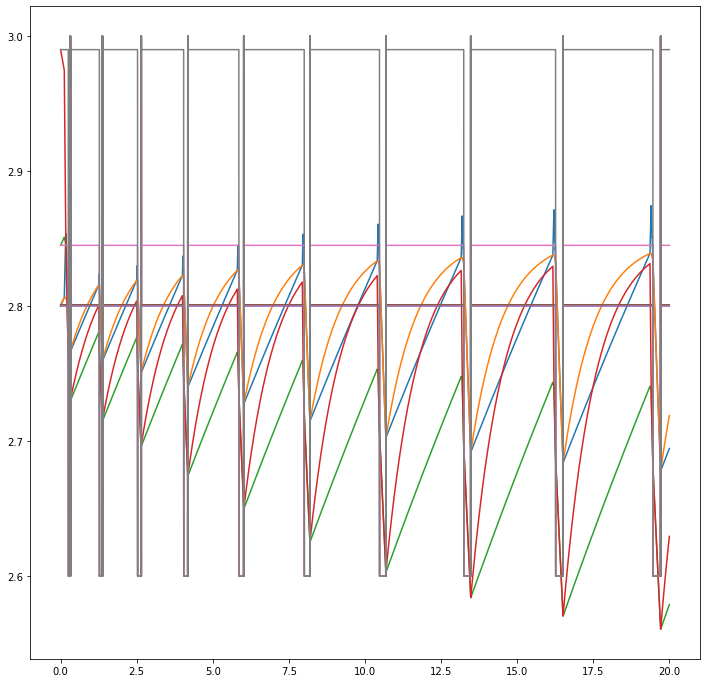

In [99]:
debug = 0
T = 20
start = bjorns_start

tstep = 10**-4
r = tstep*10

n = int(T/tstep)
print('n =',n)

tt = np.linspace(0, T, n)

yyzz = bi_model(tstep,r,eps,start = start,debug=debug,solve_method ='nr')

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.plot(tt,yyzz[0])
ax.plot(tt,yyzz[1])
